In [1]:
import yt 

In [2]:
import numpy as np 

In [3]:
from yt.utilities.lib.pixelization_routines import sample_arbitrary_points_in_grid

In [4]:
sample_arbitrary_points_in_grid?

Signature:     
sample_arbitrary_points_in_grid(
    buff,
    bpos_0,
    bpos_1,
    bpos_2,
    pos_0,
    pos_1,
    pos_2,
    pos_0_dx,
    pos_1_dx,
    pos_2_dx,
    indices,
    data,
    *,
    return_mask=0,
)
Call signature: sample_arbitrary_points_in_grid(*args, **kwargs)
Type:           cython_function_or_method
String form:    <cyfunction sample_arbitrary_points_in_grid at 0x11e595d80>
Docstring:     
a 1D buffer pixelization. maybe you want to reshape it to be an image? or
    sample an arbitrary set of points? maybe this is useful

Parameters
buff: 1d buffer array, modified in place to fill
bpos_0, _1, _2: 1D arrays, the coordinates to sample
native_x, y, z : 1D arrays, cell centers in their native coordinates
native_dx, dy, dz : 1D positions cell widths in their native coordinates
indices: 1D array, indices of the cells
data : 1D array, actual data values

In [5]:
from yt.testing import fake_amr_ds

In [6]:
# ds = fake_amr_ds()
ds = yt.load_sample("IsolatedGalaxy")

yt : [INFO     ] 2023-12-21 13:31:57,597 Sample dataset found in '/Users/chavlin/data/yt_data/IsolatedGalaxy/galaxy0030/galaxy0030'
yt : [INFO     ] 2023-12-21 13:31:58,308 Parameters: current_time              = 0.0060000200028298
yt : [INFO     ] 2023-12-21 13:31:58,309 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2023-12-21 13:31:58,309 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-12-21 13:31:58,309 Parameters: domain_right_edge         = [1. 1. 1.]
yt : [INFO     ] 2023-12-21 13:31:58,310 Parameters: cosmological_simulation   = 0


In [7]:
ad = ds.all_data()

# orig grid and values
pos_0 = ad['index', 'x'].d
pos_1 = ad['index', 'y'].d
pos_2 = ad['index', 'z'].d
pos_0_dx = ad['index', 'dx'].d
pos_1_dx = ad['index', 'dy'].d
pos_2_dx = ad['index', 'dz'].d
# data = ad['stream', 'Density'].d
data = ad['gas', 'density'].d

indices = np.arange(0, pos_0_dx.size)

Parsing Hierarchy : 100%|██████████████████████████████████████████████████████████| 173/173 [00:00<00:00, 30156.04it/s]
yt : [INFO     ] 2023-12-21 13:31:58,334 Gathering a field list (this may take a moment.)


In [8]:
# sample points 
import numpy as np
bpos_0 = np.array([0.2, 0.3, 0.4])
bpos_1 = np.array([0.2, 0.3, 0.4])
bpos_2 = np.array([0.2, 0.3, 0.4])
buff = np.zeros((3,))

In [9]:
buff.shape
np.zeros(buff.shape).ndim

1

In [10]:
ds.domain_right_edge

In [11]:
sample_arbitrary_points_in_grid(buff, bpos_0, bpos_1, bpos_2, 
                                pos_0, pos_1, pos_2, 
                                pos_0_dx, pos_1_dx, pos_2_dx,
                                indices, 
                                data)

In [12]:
buff

array([4.97026718e-31, 4.97426883e-31, 2.35961319e-30])

In [17]:
%%time
buff = np.zeros((100, 100))
orig_shape = buff.shape
xvals = np.linspace(.1, .9, buff.shape[0])
yvals = np.linspace(.1, .9, buff.shape[1])
bpos_0, bpos_1 = np.meshgrid(xvals, yvals)
bpos_0 = bpos_0.ravel()
bpos_1 = bpos_1.ravel()
bpos_2 = np.full(bpos_1.shape, 0.5) # sampling at fixed z 
buff = buff.ravel() 

sample_arbitrary_points_in_grid(buff, bpos_0, bpos_1, bpos_2, 
                                pos_0, pos_1, pos_2, 
                                pos_0_dx, pos_1_dx, pos_2_dx,
                                indices, 
                                data)

CPU times: user 23.3 s, sys: 337 ms, total: 23.7 s
Wall time: 23.7 s


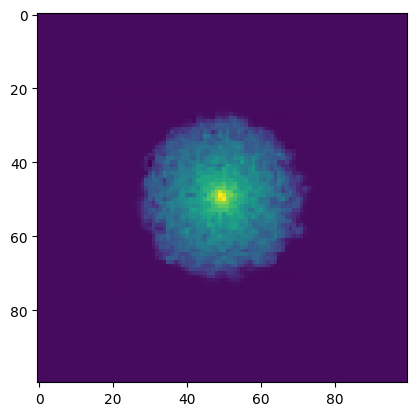

In [18]:
import matplotlib.pyplot as plt 
# buff[buff==0] = np.min(buff[buff>0])
plt.imshow(np.log10(buff.reshape(orig_shape)))

In [25]:
g = ds.index.grids[0]

In [29]:

for ch in g.chunks([('index','x')], 'io'):
    print(1)

1


In [36]:
from dask import delayed, compute

In [65]:
buff = np.zeros((500, 500))
orig_shape = buff.shape
xvals = np.linspace(.1, .9, buff.shape[0])
yvals = np.linspace(.1, .9, buff.shape[1])
bpos_0, bpos_1 = np.meshgrid(xvals, yvals)
bpos_0 = bpos_0.ravel()
bpos_1 = bpos_1.ravel()
bpos_2 = np.full(bpos_1.shape, 0.5) # sampling at fixed z 
buff = buff.ravel() 

In [41]:
pos_0.size / 1e6

3.64446

In [42]:
ad = ds.all_data()

In [48]:
ad._derived_quantity_chunking

'io'

In [71]:
from dask import delayed, compute 

def process_chunk(ch, buff, bpos_0, bpos_1, bpos_2):
    pos_0 = ch['index', 'x'].d
    pos_1 = ch['index', 'y'].d
    pos_2 = ch['index', 'z'].d
    pos_0_dx = ch['index', 'dx'].d
    pos_1_dx = ch['index', 'dy'].d
    pos_2_dx = ch['index', 'dz'].d
    data = ch['gas', 'density'].d
    indi = np.arange(0, pos_0_dx.size)
    sample_arbitrary_points_in_grid(buff, bpos_0, bpos_1, bpos_2, 
                                    pos_0, pos_1, pos_2, 
                                    pos_0_dx, pos_1_dx, pos_2_dx,
                                    indi, 
                                    data)
    return buff
    
chunks = ad.chunks(
            [], chunking_style='io'
        )

buffs_by_chunk = []
for ch in chunks:
    # orig grid and values
    buffs_by_chunk.append(delayed(process_chunk)(ch, buff, bpos_0, bpos_1, bpos_2))

In [72]:
%%time
buffs = compute(*buffs_by_chunk)

KeyboardInterrupt: 

In [73]:
final_buff = np.sum(buffs,axis=0)

In [74]:
final_buff.shape

(10000,)

In [75]:
import matplotlib.pyplot as plt 
# buff[buff==0] = np.min(buff[buff>0])
plt.imshow(np.log10(final_buff.reshape(orig_shape)))

ValueError: cannot reshape array of size 10000 into shape (500,500)

In [85]:
buff = np.zeros((400, 400))
orig_shape = buff.shape
xvals = np.linspace(.1, .9, buff.shape[0])
yvals = np.linspace(.1, .9, buff.shape[1])
bpos_0, bpos_1 = np.meshgrid(xvals, yvals)
bpos_0 = bpos_0.ravel()
bpos_1 = bpos_1.ravel()
bpos_2 = np.full(bpos_1.shape, 0.5) # sampling at fixed z 
buff = buff.ravel() 

coords = np.column_stack([bpos_0, bpos_1, bpos_2])
buff = ds.find_field_values_at_points(('gas', 'density'), coords).reshape(orig_shape)

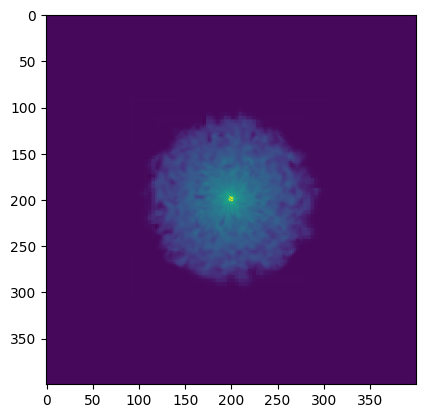

In [88]:
plt.imshow(np.log10(buff))

In [89]:
ds = fake_amr_ds(geometry='spherical')

yt : [INFO     ] 2023-12-21 14:31:00,184 Parameters: current_time              = 0.0
yt : [INFO     ] 2023-12-21 14:31:00,189 Parameters: domain_dimensions         = [32 32 32]
yt : [INFO     ] 2023-12-21 14:31:00,207 Parameters: domain_left_edge          = [0. 0. 0.]
yt : [INFO     ] 2023-12-21 14:31:00,210 Parameters: domain_right_edge         = [1.         3.14159265 6.28318531]
yt : [INFO     ] 2023-12-21 14:31:00,213 Parameters: cosmological_simulation   = 0


In [ ]:
def cart_to_sp(x, y, z):
    r = np.sqrt(x*x+y*y+z*z)
    phi = np.atan2(y, x)
    theta = np.acos
    